In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !unzip /content/drive/MyDrive/Chest\ X-ray/Result_2.zip
# !unzip /content/drive/MyDrive/Chest\ X-ray/data/vinbigdata-chest-xray-resized-png-1024x1024.zip

In [ ]:
# !pip install catboost
# !sudo apt-get install -y --no-install-recommends \
#     cuda-10-2 \
#     libcudnn7=7.6.5.32-1+cuda10.2  \
#     libcudnn7-dev=7.6.5.32-1+cuda10.2;
# !sudo apt-get install -y --no-install-recommends \
#     libnvinfer7=7.0.0-1+cuda10.2 \
#     libnvinfer-dev=7.0.0-1+cuda10.2 \
#     libnvinfer-plugin7=7.0.0-1+cuda10.2;
# !pip install PyYAML

In [ ]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy as sp


import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb



# --- setup ---
pd.set_option('max_columns', 50)


In [ ]:
!nvidia-smi

Mon Feb  1 15:22:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch

torch.__version__

'1.7.0+cu101'

In [ ]:
!pip install detectron2 -f \
  https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html
     |████████████████████████████████| 645kB 4.2MB/s 
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pickle
from pathlib import Path

import cv2
import pandas as pd
from detectron2.structures import BoxMode
from tqdm import tqdm


def get_vinbigdata_dicts(
    imgdir: Path, train: pd.DataFrame, use_cache: bool = True, debug: bool = True,
):
    debug_str = f"_debug{int(debug)}"
    cache_path = Path(".") / f"dataset_dicts_cache{debug_str}.pkl"
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        train_meta = pd.read_csv(imgdir / "train_meta.csv")
        if debug:
            train_meta = train_meta.iloc[:500]  # For debug....

        # Load 1 image to get image size.
        image_id = train_meta.loc[0, "image_id"]
        image_path = str(imgdir / "train" / f"{image_id}.png")
        image = cv2.imread(image_path)
        resized_height, resized_width, ch = image.shape
        print(f"image shape: {image.shape}")

        dataset_dicts = []
        for index, train_meta_row in tqdm(train_meta.iterrows(), total=len(train_meta)):
            record = {}

            image_id, height, width = train_meta_row.values
            filename = str(imgdir / "train" / f"{image_id}.png")
            record["file_name"] = filename
            record["image_id"] = index
            record["height"] = resized_height
            record["width"] = resized_width
            objs = []
            for index2, row in train.query("image_id == @image_id").iterrows():
                # print(row)
                # print(row["class_name"])
                # class_name = row["class_name"]
                class_id = row["class_id"]
                if class_id == 14:
                    # It is "No finding"
                    # This annotator does not find anything, skip.
                    pass
                else:
                    # bbox_original = [int(row["x_min"]), int(row["y_min"]), int(row["x_max"]), int(row["y_max"])]
                    h_ratio = resized_height / height
                    w_ratio = resized_width / width
                    bbox_resized = [
                        int(row["x_min"]) * w_ratio,
                        int(row["y_min"]) * h_ratio,
                        int(row["x_max"]) * w_ratio,
                        int(row["y_max"]) * h_ratio,
                    ]
                    obj = {
                        "bbox": bbox_resized,
                        "bbox_mode": BoxMode.XYXY_ABS,
                        "category_id": class_id,
                    }
                    objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)
        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    print(f"Load from cache {cache_path}")
    with open(cache_path, mode="rb") as f:
        dataset_dicts = pickle.load(f)
    return dataset_dicts


def get_vinbigdata_dicts_test(
    imgdir: Path, test_meta: pd.DataFrame, use_cache: bool = True, debug: bool = True,
):
    debug_str = f"_debug{int(debug)}"
    cache_path = Path(".") / f"dataset_dicts_cache_test{debug_str}.pkl"
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        # test_meta = pd.read_csv(imgdir / "test_meta.csv")
        if debug:
            test_meta = test_meta.iloc[:500]  # For debug....

        # Load 1 image to get image size.
        image_id = test_meta.loc[0, "image_id"]
        image_path = str(imgdir / "test" / f"{image_id}.png")
        image = cv2.imread(image_path)
        resized_height, resized_width, ch = image.shape
        print(f"image shape: {image.shape}")

        dataset_dicts = []
        for index, test_meta_row in tqdm(test_meta.iterrows(), total=len(test_meta)):
            record = {}

            image_id, height, width = test_meta_row.values
            filename = str(imgdir / "test" / f"{image_id}.png")
            record["file_name"] = filename
            record["image_id"] = index
            record["height"] = resized_height
            record["width"] = resized_width
            # objs = []
            # record["annotations"] = objs
            dataset_dicts.append(record)
        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    print(f"Load from cache {cache_path}")
    with open(cache_path, mode="rb") as f:
        dataset_dicts = pickle.load(f)
    return dataset_dicts


In [ ]:
# Methods for prediction for this competition
from math import ceil
from typing import Any, Dict, List
import os
import cv2
import detectron2
import numpy as np
from numpy import ndarray
import pandas as pd
import torch
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import ColorMode, Visualizer
from tqdm import tqdm
import matplotlib.pyplot as plt 

def format_pred(labels: ndarray, boxes: ndarray, scores: ndarray) -> str:
    pred_strings = []
    for label, score, bbox in zip(labels, scores, boxes):
        xmin, ymin, xmax, ymax = bbox.astype(np.int64)
        pred_strings.append(f"{label} {score} {xmin} {ymin} {xmax} {ymax}")
    return " ".join(pred_strings)


def predict_batch(predictor: DefaultPredictor, im_list: List[ndarray]) -> List:
    with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
        inputs_list = []
        for original_image in im_list:
            # Apply pre-processing to image.
            if predictor.input_format == "RGB":
                # whether the model expects BGR inputs or RGB
                original_image = original_image[:, :, ::-1]
            height, width = original_image.shape[:2]
            image = predictor.aug.get_transform(original_image).apply_image(original_image)
            image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
            inputs = {"image": image, "height": height, "width": width}
            inputs_list.append(inputs)
        predictions = predictor.model(inputs_list)
        return predictions


** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [ ]:
# --- utils ---
from pathlib import Path
from typing import Any, Union

import yaml


def save_yaml(filepath: Union[str, Path], content: Any, width: int = 120):
    with open(filepath, "w") as f:
        yaml.dump(content, f, width=width)


def load_yaml(filepath: Union[str, Path]) -> Any:
    with open(filepath, "r") as f:
        content = yaml.full_load(f)
    return content


In [ ]:
# --- configs ---
thing_classes = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis"
]
category_name_to_id = {class_name: index for index, class_name in enumerate(thing_classes)}


In [ ]:
# --- flags ---
from dataclasses import dataclass
from typing import Dict


@dataclass
class Flags:
    # General
    debug: bool = True
    outdir: str = "results/det"

    # Data config
    imgdir_name: str = "vinbigdata-chest-xray-resized-png-1024x1024"
    # Training config
    iter: int = 50000
    ims_per_batch: int = 2  # images per batch, this corresponds to "total batch size"
    num_workers: int = 4
    base_lr: float = 0.00025
    roi_batch_size_per_image: int = 512

    def update(self, param_dict: Dict) -> "Flags":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self


In [ ]:
flags_dict = {
    "debug": False,
    "outdir": "results/debug", 
    "imgdir_name": "vinbigdata-chest-xray-resized-png-1024x1024",
    "iter": 50000,  # debug, small value should be set.
    "roi_batch_size_per_image": 512  # faster, and good enough for this toy dataset (default: 512)
}

In [ ]:
import dataclasses
flags = Flags().update(flags_dict)
print("flags", flags)
debug = flags.debug
outdir = Path(flags.outdir)
os.makedirs(str(outdir), exist_ok=True)
flags_dict = dataclasses.asdict(flags)
save_yaml(outdir / "flags.yaml", flags_dict)

flags Flags(debug=False, outdir='results/debug', imgdir_name='vinbigdata-chest-xray-resized-png-1024x1024', iter=50000, ims_per_batch=2, num_workers=4, base_lr=0.00025, roi_batch_size_per_image=512)


In [ ]:
!cp /content/results/v9/model_final.pth /content/vinbigdata-r50fpn3x-512px
!cp /content/results/debug/flags.yaml /content/vinbigdata-r50fpn3x-512px
# !unzip /content/drive/MyDrive/Chest\ X-ray/vinbigdata-chest-xray-resized-png-256x256.zip

flags Flags(debug=False, outdir='results/debug', imgdir_name='vinbigdata-chest-xray-resized-png-1024x1024', iter=50000, ims_per_batch=2, num_workers=4, base_lr=0.00025, roi_batch_size_per_image=512)
cfg.OUTPUT_DIR ./output -> results/debug
Original thresh 0.05
Changed  thresh 0.0


 41%|████▏     | 1238/3000 [00:00<00:00, 12377.53it/s]

vinbigdata-chest-xray-resized-png-1024x1024
Creating data...
image shape: (1024, 1024, 3)


  0%|          | 0/750 [00:00<?, ?it/s]

Load from cache dataset_dicts_cache_test_debug0.pkl


/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()
100%|██████████| 750/750 [04:19<00:00,  2.89it/s]


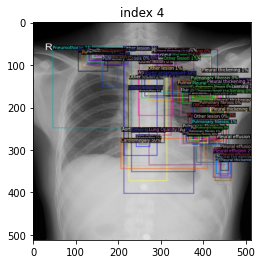

In [ ]:
inputdir = Path("./")
traineddir = inputdir / "vinbigdata-r50fpn3x-512px"

# flags = Flags()
flags: Flags = Flags().update(load_yaml(str(traineddir/"flags.yaml")))
print("flags", flags)
debug = flags.debug
# flags_dict = dataclasses.asdict(flags)
outdir = Path(flags.outdir)
os.makedirs(str(outdir), exist_ok=True)

# --- Read data ---
imgdir = inputdir / flags.imgdir_name
# Read in the data CSV files
# train = pd.read_csv(datadir / "train.csv")
test_meta = pd.read_csv(inputdir / "test_meta.csv")


cfg = get_cfg()
original_output_dir = cfg.OUTPUT_DIR
cfg.OUTPUT_DIR = str(outdir)
print(f"cfg.OUTPUT_DIR {original_output_dir} -> {cfg.OUTPUT_DIR}")

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("vinbigdata_train",)
cfg.DATASETS.TEST = ()
# cfg.DATASETS.TEST = ("vinbigdata_train",)
# cfg.TEST.EVAL_PERIOD = 50
cfg.DATALOADER.NUM_WORKERS = 2
# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = flags.base_lr  # pick a good LR
cfg.SOLVER.MAX_ITER = flags.iter
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = flags.roi_batch_size_per_image
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thing_classes)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

### --- Inference & Evaluation ---
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
# path to the model we just trained
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.WEIGHTS = str(traineddir / "model_final.pth")
print("Original thresh", cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)  # 0.05
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.0   # set a custom testing threshold
print("Changed  thresh", cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)  # 0.0
predictor = DefaultPredictor(cfg)
print(imgdir)

DatasetCatalog.register(
    "Vinbig_test5", lambda: get_vinbigdata_dicts_test(imgdir, test_meta, debug=debug)
)
MetadataCatalog.get("Vinbig_test5").set(thing_classes=thing_classes)
metadata = MetadataCatalog.get("Vinbig_test5")
dataset_dicts = get_vinbigdata_dicts_test(imgdir, test_meta, debug=debug)

if debug:
    dataset_dicts = dataset_dicts[:100]

results_list = []
index = 0
batch_size = 4

for i in tqdm(range(ceil(len(dataset_dicts) / batch_size))):
    inds = list(range(batch_size * i, min(batch_size * (i + 1), len(dataset_dicts))))
    dataset_dicts_batch = [dataset_dicts[i] for i in inds]
    im_list = [cv2.imread(d["file_name"]) for d in dataset_dicts_batch]
    outputs_list = predict_batch(predictor, im_list)

    for im, outputs, d in zip(im_list, outputs_list, dataset_dicts_batch):
        resized_height, resized_width, ch = im.shape
        
        # outputs = predictor(im)
        if index < 5:
            # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
            v = Visualizer(
                im[:, :, ::-1],
                metadata=metadata,
                scale=0.5,
                instance_mode=ColorMode.IMAGE_BW
                # remove the colors of unsegmented pixels. This option is only available for segmentation models
            )
            out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            cv2.imwrite(str(outdir / f"pred_{index}.jpg"), out.get_image()[:, :, ::-1])
            plt.title(f"index {index}")
            plt.imshow(out.get_image()[:, :, ::-1])

        assert d["image_id"] == index
        image_id, dim0, dim1 = test_meta.iloc[index].values

        instances = outputs["instances"]
        if len(instances) == 0:
            # No finding, let's set 14 0 0 0 0.
            result = {"image_id": image_id, "PredictionString": "14 1.0 0 0 1 1"}
        else:
            # Find some bbox...
            # print(f"index={index}, find {len(instances)} bbox.")
            fields: Dict[str, Any] = instances.get_fields()
            pred_classes = fields["pred_classes"]  # (n_boxes,)
            pred_scores = fields["scores"]
            # shape (n_boxes, 4). (xmin, ymin, xmax, ymax)
            pred_boxes = fields["pred_boxes"].tensor

            h_ratio = dim0 / resized_height
            w_ratio = dim1 / resized_width
            pred_boxes[:, [0, 2]] *= w_ratio
            pred_boxes[:, [1, 3]] *= h_ratio

            pred_classes_array = pred_classes.cpu().numpy()
            pred_boxes_array = pred_boxes.cpu().numpy()
            pred_scores_array = pred_scores.cpu().numpy()

            result = {
                "image_id": image_id,
                "PredictionString": format_pred(
                    pred_classes_array, pred_boxes_array, pred_scores_array
                ),
            }
        results_list.append(result)
        index += 1

In [ ]:
submission_det = pd.DataFrame(results_list, columns=['image_id', 'PredictionString'])
submission_det.to_csv(outdir/"submission_det.csv", index=False)
submission_det

,image_id,PredictionString
0,83caa8a85e03606cf57e49147d7ac569,3 0.9919421672821045 782 1066 1826 1682 11 0.4...
1,7550347fa2bb96c2354a3716dfa3a69c,0 0.9710851311683655 1216 713 1539 1141 3 0.64...
2,74b23792db329cff5843e36efb8aa65a,10 0.16016001999378204 2316 2414 2432 2556 11 ...
3,94568a546be103177cb582d3e91cd2d8,3 0.976021945476532 642 1594 1507 1917 9 0.622...
4,6da36354fc904b63bc03eb3884e0c35c,13 0.9798069000244141 1490 727 1691 836 9 0.76...
...,...,...
2995,7f5503caa936a623b4388fbd88e890c5,0 0.9010471105575562 1367 787 1656 1157 3 0.33...
2996,c97e54a78bab9c05ce2e04fe6c284bcd,0 0.987040102481842 1661 964 2080 1408 3 0.963...
2997,33218cf183c1224a74ccfb514e827e15,13 0.7707513570785522 536 656 1144 1694 3 0.46...
2998,04b700c4815f088728db9f093c739707,0 0.8263511061668396 1292 1052 1587 1382 11 0....


In [ ]:
pred_2class = pd.read_csv(inputdir/"2-cls test pred.csv")
pred_2class

,image_id,target
0,002a34c58c5b758217ed1f584ccbcfe9,0.013326
1,004f33259ee4aef671c2b95d54e4be68,0.037235
2,008bdde2af2462e86fd373a445d0f4cd,0.939700
3,009bc039326338823ca3aa84381f17f1,0.123799
4,00a2145de1886cb9eb88869c85d74080,0.654006
...,...,...
2995,ff91fb82429a27521bbec8569b041f02,0.936325
2996,ff9fcc4087ed5e941209aa3fa948e364,0.963583
2997,ffaa288c8abca300974f043b57d81521,0.178720
2998,ffc441e0c8b7153844047483a577e7c3,0.225196


In [ ]:
NORMAL = "14 1 0 0 1 1"
low_threshold = 0.0
high_threshold = 0.95

pred_det_df = submission_det  # You can load from another submission.csv here too.
n_normal_before = len(pred_det_df.query("PredictionString == @NORMAL"))
merged_df = pd.merge(pred_det_df, pred_2class, on="image_id", how="left")

# 1. p < low_threshold                   -> "Keep": Do nothing, Keep det prediction.
# 2. low_threshold <= p < high_threshold -> "Add": Just "Add" Normal prediction
# 3. high_threshold <= p                 -> "Replace": Replace with Normal prediction

if "target" in merged_df.columns:
    merged_df["class0"] = 1 - merged_df["target"]

c0, c1, c2 = 0, 0, 0
for i in range(len(merged_df)):
    p0 = merged_df.loc[i, "class0"]
    if p0 < low_threshold:
        # Keep, do nothing.
        c0 += 1
    elif low_threshold <= p0 and p0 < high_threshold:
        # Add, keep "det" preds and add normal pred.
        merged_df.loc[i, "PredictionString"] += f" 14 {p0} 0 0 1 1"
        c1 += 1
    else:
        # Replace, remove all "det" preds.
        merged_df.loc[i, "PredictionString"] = NORMAL
        c2 += 1

n_normal_after = len(merged_df.query("PredictionString == @NORMAL"))
print(
    f"n_normal: {n_normal_before} -> {n_normal_after} with threshold {low_threshold} & {high_threshold}"
)
print(f"Keep {c0} Add {c1} Replace {c2}")
submission_filepath = str(outdir / "submission.csv")
submission_df = merged_df[["image_id", "PredictionString"]]
submission_df.to_csv(submission_filepath, index=False)
print(f"Saved to {submission_filepath}")

n_normal: 0 -> 1700 with threshold 0.0 & 0.95
Keep 0 Add 1300 Replace 1700
Saved to results/debug/submission.csv


In [ ]:
import pandas as pd

pred_2class = pd.read_csv('/content/2-cls test pred.csv')
submission_det = pd.read_csv('/content/submission_det.csv')

In [ ]:
import pandas as pd

pred_2class = pd.read_csv('/content/2-cls test pred.csv')
submission_det = pd.read_csv('/content/submission_det.csv')

NORMAL = "14 1 0 0 1 1"
low_threshold = 0.3
high_threshold = 0.95

pred_det_df = submission_det  # You can load from another submission.csv here too.
n_normal_before = len(pred_det_df.query("PredictionString == @NORMAL"))
merged_df = pd.merge(pred_det_df, pred_2class, on="image_id", how="left")

# 1. p < low_threshold                   -> "Keep": Do nothing, Keep det prediction.
# 2. low_threshold <= p < high_threshold -> "Add": Just "Add" Normal prediction
# 3. high_threshold <= p                 -> "Replace": Replace with Normal prediction

if "target" in merged_df.columns:
    merged_df["class0"] = 1 - merged_df["target"]

c0, c1, c2 = 0, 0, 0
for i in range(len(merged_df)):
    p0 = merged_df.loc[i, "class0"]
    if p0 < low_threshold:
        # Keep, do nothing.
        c0 += 1
    elif low_threshold <= p0 and p0 < high_threshold:
        # Add, keep "det" preds and add normal pred.
        merged_df.loc[i, "PredictionString"] += f" 14 {p0} 0 0 1 1"
        c1 += 1
    else:
        # Replace, remove all "det" preds.
        merged_df.loc[i, "PredictionString"] = NORMAL
        c2 += 1

n_normal_after = len(merged_df.query("PredictionString == @NORMAL"))
print(
    f"n_normal: {n_normal_before} -> {n_normal_after} with threshold {low_threshold} & {high_threshold}"
)
print(f"Keep {c0} Add {c1} Replace {c2}")
submission_filepath = str("submission.csv")
submission_df = merged_df[["image_id", "PredictionString"]]
submission_df.to_csv(submission_filepath, index=False)
print(f"Saved to {submission_filepath}")

n_normal: 0 -> 1700 with threshold 0.3 & 0.95
Keep 438 Add 862 Replace 1700
Saved to submission.csv
